# Ocular Diseases Classification using Deep Learning Techniques
## Project Overview
This project aims to develop a deep learning model for the classification of retinal images to identify various eye diseases. The focus is on four specific conditions: **Normal, Diabetic Retinopathy, Cataract, and Glaucoma**.

By analyzing these images, we can assist in early diagnosis and treatment, ultimately improving patient outcomes.

## Dataset Description
The dataset used for this project comprises retinal images categorized into four classes:
* Normal: Healthy retinal images with no abnormalities
* Diabetic Retinopathy: Images showing signs of diabetic eye disease.
* Cataract: Images indicating the presence of cataracts in the lens of the eye.
* Glaucoma: Images that reveal signs of glaucoma, which affects the optic nerve.

Each class contains approximately 1,000 images, providing a balanced dataset for training and evaluation. The images have been sourced from various reputable databases, including:

* IDRiD: Indian Diabetic Retinopathy Image Dataset
* Ocular Recognition: A database focused on ocular disease recognition
* HRF: High-Resolution Fundus dataset

Source of Dataset:
*https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification/data*

In [52]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import v2
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchinfo import summary

%autosave 30

Autosaving every 30 seconds


In [28]:
telltimefnx = lambda :print(f"Time Now: {pd.Timestamp.now().strftime('%Y.%m.%d %I:%M %p')}")
telltimefnx()

Time Now: 2024.11.29 11:38 PM


In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Dataset Exploration
* Identification of number of samples for each category
* Creation of a unified dataframe, containing paths and respective category

In [29]:
dataPath = r"C:\Users\asuto\Desktop\Work\Eye Diseases\dataset"
os.listdir(dataPath)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [30]:
%%time
total = 0
for disease in os.listdir(dataPath):
    diseasePath = os.path.join(dataPath,disease)
    print(f"Number of samples for {disease} case: {len(os.listdir(diseasePath))}")
    total += len(os.listdir(diseasePath))
print(f"Total samples: {total}")

Number of samples for cataract case: 1038
Number of samples for diabetic_retinopathy case: 1098
Number of samples for glaucoma case: 1007
Number of samples for normal case: 1074
Total samples: 4217
CPU times: total: 31.2 ms
Wall time: 46.9 ms


In [31]:
%%time
diseaseMap = {"filepath":[],"label":[]}

for disease in tqdm(os.listdir(dataPath)):
    diseasePath = os.path.join(dataPath,disease)

    for path in os.listdir(diseasePath):
        diseaseMap['filepath'].append(os.path.join(dataPath,disease,path))
        diseaseMap['label'].append(disease)

opticDf = pd.DataFrame(diseaseMap).sample(frac=1)
opticDf.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 128.05it/s]

CPU times: total: 31.2 ms
Wall time: 31.2 ms


,filepath,label
3915,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,normal
2508,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,glaucoma
1362,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,diabetic_retinopathy
1225,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,diabetic_retinopathy
1651,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,diabetic_retinopathy


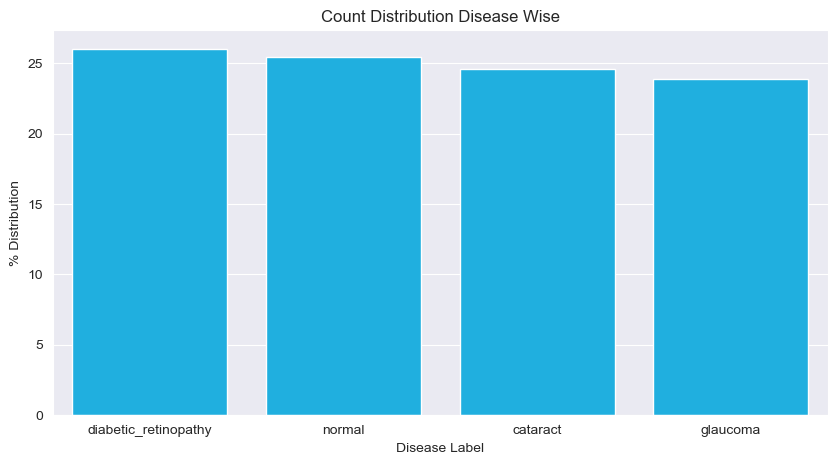

In [32]:
plt.figure(figsize=(10,5),dpi=100)
sns.barplot(opticDf.label.value_counts(normalize=True)*100,color='deepskyblue')
plt.xlabel("Disease Label")
plt.ylabel("% Distribution")
plt.title('Count Distribution Disease Wise')
plt.show()

## Torch Implementation

In [34]:
torch.cuda.is_available()

True

In [44]:
#Target Image Size. Original Image Size is (512,512)
imageSize = (224, 224)
color = 'rgb'
colorChannel = 3
imageShape = (imageSize[0],imageSize[1],colorChannel)
batch_size = 6

In [45]:
transformFnx = v2.Compose([v2.ToImage(),v2.Resize(imageSize),v2.RandomHorizontalFlip(0.5),v2.ToDtype(torch.float32, scale=True)])

In [46]:
# dataPath = "/content/drive/MyDrive/Datasets/Optical Diseases"
dataset = datasets.ImageFolder(dataPath,transform=transformFnx)

trainData,valData,testData = torch.utils.data.random_split(dataset,[0.7,0.15,0.15])


dataLoad_train = DataLoader(trainData,batch_size=batch_size,shuffle=True)
dataLoad_val = DataLoader(valData,batch_size=batch_size,shuffle=True)
dataLoad_test = DataLoader(testData,batch_size=batch_size,shuffle=True)

In [47]:
dataset

Dataset ImageFolder
    Number of datapoints: 4217
    Root location: C:\Users\asuto\Desktop\Work\Eye Diseases\dataset
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ToDtype(scale=True)
           )

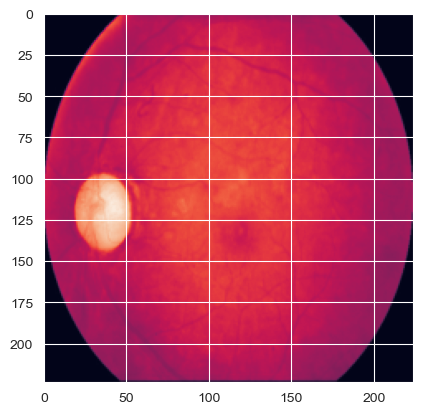

In [48]:
images, labels = next(iter(dataLoad_train))
plt.imshow(images[0][0])
plt.show()

## AlexNet

In [67]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 4):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            #layer 1
            nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),

            #layer 2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            #layer 3
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            #layer 4
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            #layer 5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            #layer 6
            nn.Dropout(p=0.5),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            #layer 7
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            #layer 8 Fin.
            nn.Linear(4096, num_classes)
        )

    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

model = AlexNet(num_classes = 4)
model.to(device)

print(summary(model,input_size=(1,3,224,224)))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 4]                    --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## Training

In [75]:
%%time
telltimefnx()
num_epochs = 5

totLoss,totLossV = [],[]

for epc in range(num_epochs):
    model.train()

    running_loss,correct,total = 0,0,0

    for inp,label in dataLoad_train:
        inp,label = inp.to(device),label.to(device)

        optimizer.zero_grad()

        output = model(inp)
        loss = criterion(output,label)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(output,1)
        total += label.size(0)
        correct += (pred==label).sum().item()
    totLoss.append(running_loss/len(dataLoad_train))
    print(f"Epoch {epc+1}/{num_epochs}, Loss: {running_loss/len(dataLoad_train)}, Accuracy: {100 * correct/total}%")

    model.eval()
    val_loss,val_correct,val_total = 0,0,0

    for inpV,labelV in dataLoad_val:
        inpV,labelV = inpV.to(device),labelV.to(device)

        outputV = model(inpV)
        lossV = criterion(outputV,labelV)

        val_loss += lossV.item()
        _,pred = torch.max(outputV,1)

        val_total += labelV.size(0)
        val_correct += (pred==labelV).sum().item()
    totLossV.append(val_loss/len(dataLoad_val))
    print(f"Validation Data: {val_loss/len(dataLoad_val):.4f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%")


telltimefnx()

Time Now: 2024.11.30 12:56 AM
Epoch 1/5, Loss: 0.8589021478726612, Accuracy: 57.892953929539296%
Validation Data: 0.7272, Validation Accuracy: 68.40%
Epoch 2/5, Loss: 0.7162029069149867, Accuracy: 64.9390243902439%
Validation Data: 0.6453, Validation Accuracy: 72.83%
Epoch 3/5, Loss: 0.6976416885428797, Accuracy: 67.17479674796748%
Validation Data: 0.6359, Validation Accuracy: 69.04%
Epoch 4/5, Loss: 0.6816588890382914, Accuracy: 67.07317073170732%
Validation Data: 0.6379, Validation Accuracy: 69.19%
Epoch 5/5, Loss: 0.6537741357384901, Accuracy: 67.71680216802169%
Validation Data: 0.6272, Validation Accuracy: 69.67%
Time Now: 2024.11.30 01:02 AM
CPU times: total: 35min 46s
Wall time: 6min


In [ ]:
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
with torch.no_grad():  # No need to compute gradients for testing
    for inputs, labels in dataLoad_test:
        # Move data to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")
